# Automated And-1
### COMS 4995 Final Project 
### Prof. Peter Belhumeur
### December 17, 2020
### Name: Shvetank Prakash
### UNI: SP3816

Note: The video, data, and saved models have all been uploaded to Google Drive and shared with the staff. The code has all been submitted via Courseworks in the zip file with this project report. I did not want to make the size of this submission massive so I did it this way. Please download the files from the Google Drive for the data, models, etc. and place the individual datasets and models in the same directory level to run the notebook as well as view my video! The name of the folder I have shared is sp3816_final_prj.

## Premise and Background

The goal of my project is to use computer vision to detect when a foul has occurred during a basketball game. A lot of work in sports has been done with machine learning involving analytics, player data, etc. More specifically, there has been a lot of work around using computer vision with video (game footage) for tracking and other tasks. I found this out when I started doing research surrounding sports and computer vision. For example, there is a fair amount of work on player tracking, ball tracking, and shot success probability in basketball using computer vision (Thomas et al., 2017). Moreover, the professor mentioned an example to me where the NFL was using computer vision to generate highlight reels of long games. 

However, after a lot of research one thing I never really found much on was using vision for detecting fouls in sports and more specifically basketball. I found plenty of research papers and literature on the other topics I mentioned, but only one single blog post about this foul topic and they did not go depth into the topic and talked more about the services offered by Microsoft Computer Vision (Thai, 2019) This was exciting to me because it seemed like a somewhat new application of computer vision that I could apply to this space. Furthermore, it seemed potentially doable to get something working despite challenges that I might run into. 

Before we get into it, though, let’s quickly discuss the use of this application. Currently, referees make all the foul calls when administering a game. However, often both fans and players complain about the poor calls made by referees. Sometimes the referees miss calls and sometimes they make bad calls (i.e. call fouls that shouldn’t have been fouls). Using computer vision to automate this process, or at least aid in making calls, could perhaps make calling fouls more precise and more consistent. Additionally, it could remove the bias from foul calls that people often complain about from referees that “star” players get away with. Finally, it could provide a substitute to referees for non professional games when referees are sometimes hard to get.

## Step 1: Data Collection

The first step in my project was collecting data. There was not a pre existing dataset for this, so I had to curate my own from scratch. I knew that hand collecting this data was not going to be scalable, so I looked into ways to scrape the web. Having never done this, I had to do a lot of research for the best ways to scrape from the Internet. Eventually I came to a solution looking at a blog post in which it showed how to scrape from Google Images (Suresh, 2020). He did provide working code on Github which I used BUT I did have to modify it to get it to work for myself and this did take a LONG time to actually get the image scraper to work finally! The code he had only scraped a few images from a Google Images search, but I needed thousands. And this was much trickier than just changing a number to get more images- I had to dive deep into the Selenium library to figure out how to fix the problem and get more images which took a while. 

Eventually I figured it out and was able to scrape thousands of images! This was actually so cool for me because when I got it working, another GitHub member asked for me to post my working solution for how to modify the original code to scrape more than just a few images. See the bottom of this [link](https://gist.github.com/Anandsure/f041cc2fad52bd1b80b659d337a9511c)! This was really cool for me since I had never really used or contributed to Open Source code before since in most of my classes we often just build our own projects from scratch for the assignments but not from Open Source code. It was really cool though taking someone's existing code, building on it, and then having somone ask for my contribution since it was a significant and useful addition! This is a skill useful in ML as the Professor mentioned how you often take someone else's code and tweak it to work for you in this space.

After scraping the images I had about 10,000 images of each class which I called 'foul' and 'clean'. I then had to manually go through ALL this data to clean it as there was a lot of garbage images that were not relevant and good for my dataset. After many days, eventually I completed the cleaning, but at the end of this I was left with only 500 images!

This data collection part was by far the hardest and most time consuming- it took a good 6 days to build the scraper, get it working, and clean the data.

If you would like to invoke the scraper, which I have included you need to do the following:
1. Download the Google Chrome Driver from [here](https://chromedriver.chromium.org/downloads). This is how you can control Chrome using software! 
2. Go inside image_scraper.py and add the path to your Chrome Driver at the top of the file
3. Add the path to the folder you would like the images to be stored in at the bottom of the file
4. Run 'python3 image_scraper.py' from the terminal and watch the magic!

I have also include a demo video in the Google Drive Folder showing it working briefly. The original dataset that I hand cleaned after scraping is called 'initial_dataset'.

## Step 2: Model Training 

Let's first import the necessary modules for our project.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18
from torchvision import transforms, datasets, utils

Now let's define some critical functions we need.

In [4]:
# Training loop for the model 
def train(model, optimizer, criterion, train_loader, device):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for batch in train_loader:
        # Move images and labels to GPU
        images = batch[0].to(device)
        labels = batch[1].to(device)
        
        # Feed images through model, compete loss, and get predictions
        outputs = model(images)  
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        
        # Add needed values to stats
        train_loss += loss.item() * images.size(0)
        train_correct += torch.sum(preds == labels.data)
        train_total += outputs.shape[0]
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return (train_loss / train_total), (train_correct.cpu().numpy() / train_total)  # convert from tensor to scalar with .numpy()


# Validation function to compute accuracy and loss on validation set
def validation(model, criterion, val_loader, device):
    model.eval()
    with torch.no_grad():
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        for batch in val_loader:
            # Move images and labels to GPU
            images = batch[0].to(device)
            labels = batch[1].to(device)

            # Feed images through model, compete loss, and get predictions
            outputs = model(images)  
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            # Add needed values to stats
            val_loss += loss.item() * images.size(0)
            val_correct += torch.sum(preds == labels.data)
            val_total += outputs.shape[0]
        
    return (val_loss / val_total), (val_correct.cpu().numpy() / val_total)  # convert from tensor to scalar with .numpy()

Let's also write our main loop which will include loading the dataset, preprocessing of it, fine tuning the model, and visualizing the results.

In [5]:
def main_loop(dataset_path, device, model, num_epochs, best_model_path):
    # Compose a transform to apply on input so it can be fed into Resnet
    # Found transforms expected by ResNet here: https://pytorch.org/hub/pytorch_vision_resnet/
    data_transforms = transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                   ])

    # Load the hand curated dataset
    dataset = datasets.ImageFolder(root=dataset_path, transform=data_transforms)
    print("Size of dataset: " + str(len(dataset)) + "\n")

    # Split the dataset into two sets to create a validation set.
    eighty = int(len(dataset) * 0.8)
    twenty = len(dataset) - eighty
    train_dataset, val_dataset = random_split(dataset, [eighty, twenty])

    # Create dataloaders for loaded training set and validation set of the images to feed through our network
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32, num_workers=4)
    val_loader = DataLoader(val_dataset, shuffle=True, batch_size=32, num_workers=4)     

    # Freeze the layers of the pretrained model
    for param in model.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model.fc.in_features   
    model.fc = nn.Linear(num_ftrs, 2) # we want our final fully connected layer to map to 2 outputs (i.e. our 2 classes)

    # Move the model to GPU
    model = model.to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

    # Train and validate the unfrozen layers for a number of epochs
    val_loss_log = []
    val_accuracy_log = []
    train_loss_log = []
    train_accuracy_log = []
    best_loss = None
    best_acc = None
    for epoch in range(num_epochs):
        # Train & Validate 
        train_loss, train_acc = train(model, optimizer, criterion, train_loader, device)
        val_loss, val_acc = validation(model, criterion, val_loader, device)
        
        # Store loss and accuracy of each epoch for plotting
        val_loss_log.append(val_loss)
        train_loss_log.append(train_loss)
        val_accuracy_log.append(val_acc)
        train_accuracy_log.append(train_acc)
        
        # Keep track of validation loss and monitor for saving best model
        if len(val_loss_log) == 0 or val_loss_log[-1] == min(val_loss_log):
                best_loss = val_loss
                best_acc = val_acc
                torch.save(model, best_model_path)
                
    # Visualize the training results
    plot_training_results(val_loss_log, val_accuracy_log, train_loss_log, train_accuracy_log, best_loss, best_acc)

We need to define our one last helper function for visualizing results in our main loop.

In [6]:
def plot_training_results(val_loss_log, val_accuracy_log, train_loss_log, train_accuracy_log, best_loss, best_acc):
    x = np.arange(1, len(val_loss_log) + 1)  # array w/ numbers of each epoch for plotting (1, 2, ... , last epoch num) 
    
    # Plot loss
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(x, np.array(val_loss_log))
    plt.plot(x, np.array(train_loss_log))
    plt.show()
    
    # Plot accuracy
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(x, np.array(val_accuracy_log))
    plt.plot(x, np.array(train_accuracy_log))
    plt.show()
    
    # Print accuracy and loss of saved model
    print("Loss of best saved model: " + str(best_loss))
    print("Accuracy of best saved model: " + str(best_acc))

Now we're ready for our first try at it! Let's see how it goes...fingers crossed!

Size of dataset: 497



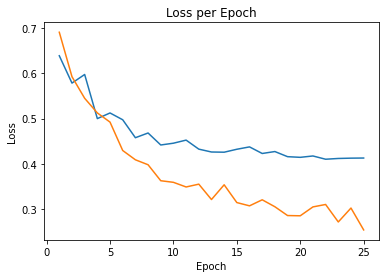

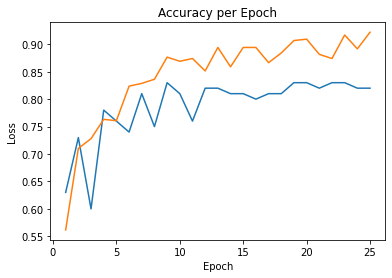

Loss of best saved model: 0.4106065607070923
Accuracy of best saved model: 0.83


In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # used to move model and data to GPU for training
model = resnet18(pretrained=True)                                      # load pretrained ResNet from PyTorch Models

main_loop("./initial_dataset", device, model, 25, "./best_model_initial_dataset.pth")

Phew! We can see that our model is learning something it appears. I had no idea how it would go, but it is good to see a validation accuracy of 0.83. 

In the plots above, the orange lines are from training and the blue lines are from validation. If we analyze these plots we can see a CLASSICAL case of overfitting that we learned in class where the training loss and accuracy keep improving even though this is not the case for the validation loss and accuracy. This is why I save the model of the best validation results and not the best training results.

However, the real test is seeing how our model generalizes to new data. 
Let's see how our model performs on the test set! Since I had such little data for my training I couldn't spare any of that data for testing, so in order to get some images to test on I had to hand collect individual images by exploring the web. For this reason, my test dataset is very small to begin with as it is just something to get a baseline with.

We will first need to define some more functions in order to test.

In [7]:
def test_set_evaluation(model, criterion, test_loader, test_dataset, show_preds=True):
    model.eval()
    with torch.no_grad():
            # Stats
            test_correct = 0
            test_total = 0
            test_loss = 0.0
            
            # Used to show some sample predictions
            if show_preds:
                figure, img_array = plt.subplots(2,3, figsize=(20, 10))
                row = 0
                col = 0
                num_left_correct = 3  # plot some correct preds
                num_left_wrong = 3    # plot some incorrect preds

            for batch in test_loader:
                # Move images and labels to GPU
                image = batch[0].to(device)
                label = batch[1].to(device)
                
                # Feed images through model, compete loss, and get predictions
                output = model(image)                
                loss = criterion(output, label)
                _, pred = torch.max(output, 1)
                
                # Add needed values to stats
                test_loss += loss.item() * image.size(0)
                test_correct += torch.sum(pred == label.data)
                test_total += output.shape[0]
                
                # Add sample prediction to plot
                if show_preds:
                    row, col, num_left_correct, num_left_wrong, img_array = plot_sample_prediction(num_left_correct, num_left_wrong, image, img_array, pred, label, output, col, row, test_dataset)
                    
            # Show sample predictions and test evaluation results
            if show_preds:
                plt.show()  
            display_test_results(test_total, test_correct, test_loss)


def plot_sample_prediction(num_left_correct, num_left_wrong, image, img_array, pred, label, output, col, row, test_dataset):
    # convert from tensors to scalars
    pred = pred.cpu().numpy()[0]   
    label = label.cpu().numpy()[0] 

    # Check if we have already plotted 3 correct and wrong sample predictions
    if (num_left_correct == 0 and pred == label) or (num_left_wrong == 0 and pred != label):
        return row, col, num_left_correct, num_left_wrong, img_array
    
    # Un-normalize the image before displaying so that it's easier for our eyes
    unnorm_img = None
    for dim, mean, std_dev in zip(image,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)):
        unnorm_img = dim.mul_(std_dev).add_(mean)
    unnorm_img = torch.clamp(unnorm_img, min=0.0, max=1.0)  # clip image to be between +/- for matplot lib 
                
    # Create label and prediction strings
    pred_str = "Prediction: " + str(test_dataset.classes[pred])
    label_str = "Label: " + str(test_dataset.classes[label])

    # Add image with title to grid of images and remove any axis ticks
    img_array[row,col].imshow(unnorm_img.permute(1,2,0).cpu())
    img_array[row,col].set_title(pred_str + ", " + label_str, size='large')
    img_array[row,col].get_yaxis().set_ticks([])
    img_array[row,col].get_xaxis().set_ticks([])
    
    # Decrement count for correct and wrong sample predictions available to plot on grid
    if pred == label:
        num_left_correct -= 1
    if pred != label:
         num_left_wrong -= 1 
    
    # Used to make sure row and col index correct for next sample plot
    col += 1
    if col == 3:
        row += 1
        col = 0
    if row == 2:
        row = 0
            
    return row, col, num_left_correct, num_left_wrong, img_array

               
def display_test_results(test_total, test_correct, test_loss):             
    print()
    print("Total: " + str(test_total))
    print("Correct: " + str(test_correct.cpu().numpy()))
    print("Test Loss: " + str(test_loss / test_total))
    print("Test Accuracy: " + str((test_correct.cpu().numpy() /  test_total)))
    

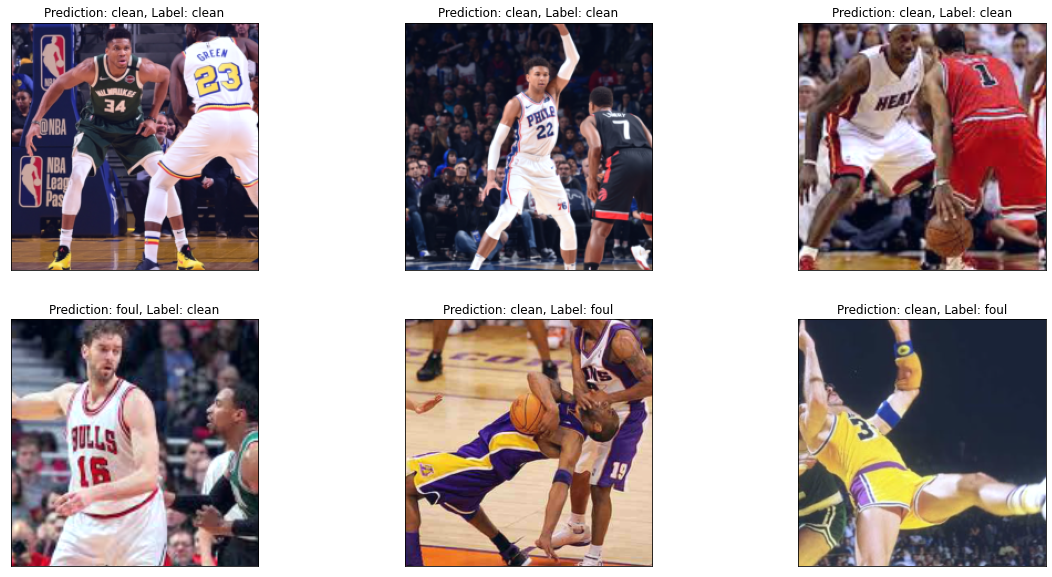


Total: 14
Correct: 10
Test Loss: 0.5328508996005569
Test Accuracy: 0.71428573


In [107]:
# Define expected transformations and expected loss function
data_transforms = transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                   ])
criterion = nn.CrossEntropyLoss()

# Load test dataset and model
test_dataset = datasets.ImageFolder(root="./initial_test_dataset", transform=data_transforms)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=1)
best_model = torch.load("best_model_initial_dataset.pth")

# Evaluate
test_set_evaluation(best_model, criterion, test_loader, test_dataset)

Above I have plotted some sample predictions with their labels in a grid!

71% accuracy is not great. We had a 12% drop from our validation accuracy results to these testing results. However, it is good to know that we can confirm that our model IS learning! Since we are above 50% accuracy, we know that the model is learning something as the Professor mentioned as well.

## Step 3: Stretch Goal - Video 

After getting this baseline MVP implementation working, I wanted to go for one of the stretch goals that I had outlined in my original project proposal- working with video. I had never done so before, and the Professor had said that if I hadn't, then it probably wasn't a good idea to try this since I would spend a lot of time just trying to get the video shapes to fit (which he was not wrong about), and this is why I made it as a stretch goal if I had time. I was able to end up incorporating this video aspect into my project though in which we can make predictions while the video is playing. As I said, I did not have any experience with video before so accomplishing this effort was awesome and a neat milestone. The way I made it manageable since I didn't have expereince was to break the video down into frames and make predictions on these. I found this nice [tutorial](https://debuggercafe.com/action-recognition-in-videos-using-deep-learning-and-pytorch/) which I had to play with A LOT to eventually get the network to fit my videos and work. I have included the source and it is called 'test_video_data.py'. I have made comments about the parts that I modified. I also left all of the other work (failed attempts, debugging, etc.) that I had to try so that you could see that it was not trivial to just get this working from the tutorial for my implementation and required many hours of work to figure out. Moreover, I had to hand collect more data and find videos of players being fouled for this part.

I have included a demo video in the Google Drive Folder showing this video part, but if you would like to try it out for yourself do the following:
1. Go to my shared folder in Google Drive and download the test_data_clips directory, the initial_test_dataset directory, and best_model_augmented_dataset_resnet152.pth model and place them at the same level as this notebook in the file system.
2. Run the following command from the terminal 'python3 test_video_data.py'.
3. If you would like to change which video is being tested on change the clip number on line 13 of test_video_data.py.
4. If you would like to change which model to test with change line 50 of the file and replace it with one of my other saved models in the drive and download it.


After viewing how the model performed on the video, my analysis was the following:
It appears that the model may be picking up on the size/location/zoom. For example, there was a clip I tested in which the the model did not detect a foul until the replay occurred which was much more zoomed in than the live play. This could make sense to me because if you look at my foul training data a lot of the images have players zoomed in on. 

## Step 4: Improvements

After accomplishing some solid results with the initial round of work and also making progress with my stretch goal, it was now time to look at ways to improve upon the MVP. While the Professor said these initial results and progress were very solid, he reccommended I try a couple more things to make it a very good project. I tried all of these recommendations below in my efforts to try and improve my results and project!

### 1st Attempted Improvement - Data Augmentation

The first thing I tried was data augmentation. Given that I had such little training data (only 500 images), this technique was sure (at least I and the Professor thought) to give a great lift to my model!

In [54]:
# Define some different transformations to augment the data 
augmentations = {
                        "orig": transforms.Compose([
                                transforms.ToTensor()
                               ]),
                        "aug1": transforms.Compose([
                                transforms.ColorJitter(brightness=0.5, contrast=0.5),
                                transforms.ToTensor(),
                               ]),
                        "aug2": transforms.Compose([
                                transforms.RandomHorizontalFlip(p=1),
                                transforms.ToTensor(),
                               ]),
                        "aug3": transforms.Compose([
                                transforms.Pad(200),
                                transforms.ToTensor(),
                               ]),
                        "aug4": transforms.Compose([
                                transforms.RandomRotation(degrees=(45)),
                                transforms.ToTensor(),
                               ])
                        }

# Use these transforms to create new data
def create_more_samples(augmentations):
    idx = 0
    # Apply each transform to make a "new" samples
    for transform in augmentations.values():
        dataset = datasets.ImageFolder(root="./initial_dataset", transform=transform)
        for img, label in dataset:
            utils.save_image(img, "./augmented_dataset/" + dataset.classes[label] + "/img_" + str(idx) + ".jpg")
            idx+=1
            
create_more_samples(augmentations)

After running the above block I generated a new dataset called 'augmented_dataset' in which there are rotated images, flipped images, padded images, the originals and more. Feel free to check out the folder if you would like to see some of the "new" augmented images. For example if you check out img_1989.jpg in the augmented dataset clean folder you will see a rotated version of an image. This took my training set size from about 500 to about 2500.

Now let's train our model using our increased dataset to see if we get any lift!

Size of dataset: 2491



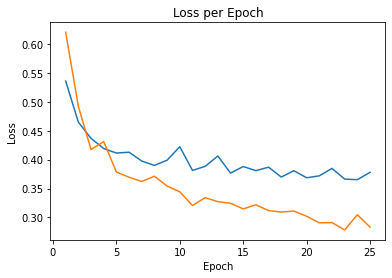

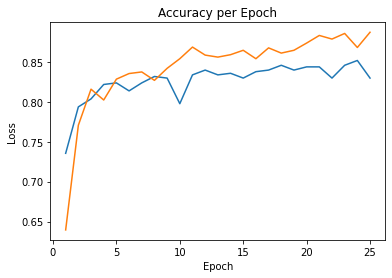

Loss of best saved model: 0.3652972737868468
Accuracy of best saved model: 0.8517034


In [108]:
# Train and Validate
model = resnet18(pretrained=True)
main_loop("./augmented_dataset", device, model, 25, "./best_model_augmented_dataset.pth")

Both the loss and accuracy have improved compared to our first attempt; however, the lift isn't as great as I had hoped for. Let's see how it performs on the test set, though, as this is the real test to see how the model generalizes.

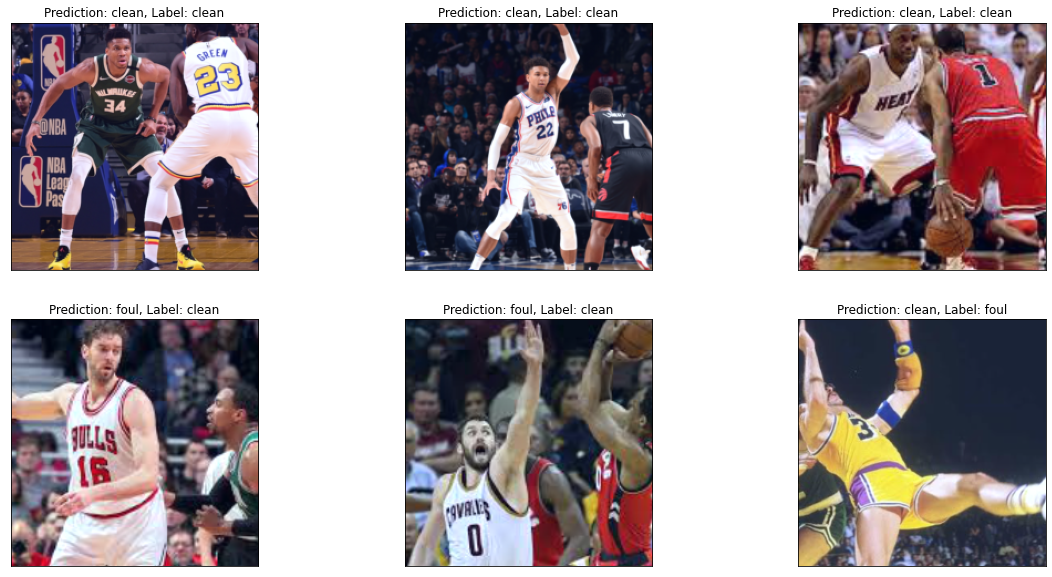


Total: 14
Correct: 10
Test Loss: 0.4313489728208099
Test Accuracy: 0.71428573


In [110]:
# Evaluate on test set
best_model = torch.load("best_model_augmented_dataset.pth")
test_set_evaluation(best_model, criterion, test_loader, test_dataset)

Well it looks like the model accuracy did not improve after all...I guess we will have to try something else!

### 2nd Attempted Improvement - ResNet152

Since I did not have that much training data and the time it took to train was not that much, I wanted to see if I could take a "monster of the shelf" as the Professor called it to see if that perhaps gave better results. To this end, I next tried to use the pretrained ResNet152, a much deeper network than ResNet18.

Let's first train ResNet152 on our smaller dataset to see how it does before training on our augmented, larger dataset.

Size of dataset: 497



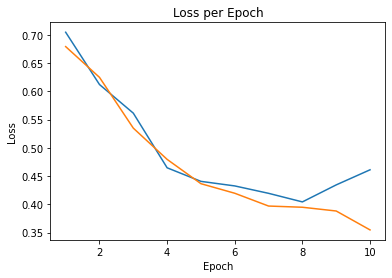

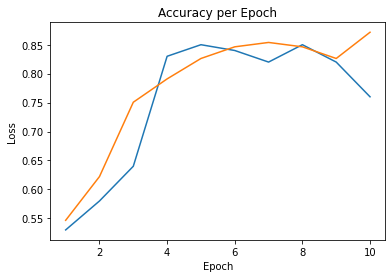

Loss of best saved model: 0.40430857181549074
Accuracy of best saved model: 0.85


In [111]:
# Train and Validate
from torchvision.models import resnet152
model = resnet152(pretrained=True)
main_loop("./initial_dataset", device, model, 10, "./best_model_initial_dataset_resnet152.pth")

Well these results are not very impressive given the cost of this larger network; the best validation loss and accuracy did not improve! But still let's check to see how it performs on the test set. 

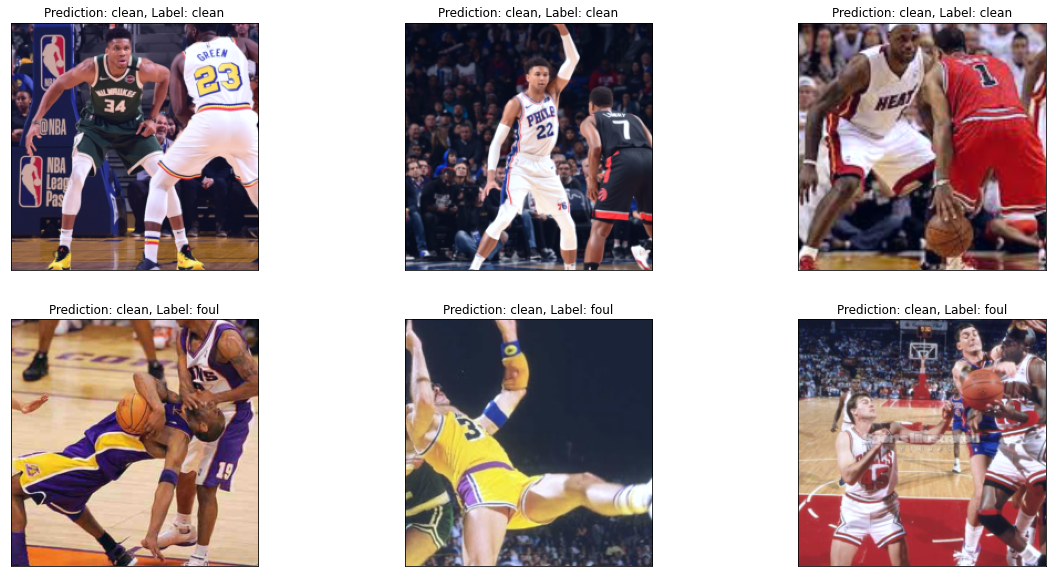


Total: 14
Correct: 11
Test Loss: 0.4309766859348331
Test Accuracy: 0.78571427


In [112]:
# Evaluate on test set
best_model = torch.load("best_model_initial_dataset_resnet152.pth")
test_set_evaluation(best_model, criterion, test_loader, test_dataset)

Okay, wow! We had about a 7% increase in our test accuracy this time! It appears that this model is performing better after all. This analysis and example really hits home the point of emphasis in class that we learned about not losing sight of the purpose of this all- having our models generalize well to new data! Even though we did not get the training results we were hoping for perhaps, what really matters are these results above and how it generalizes to new, unseen data.

Now let's train on our larger augmented dataset to see how the model performs.

Size of dataset: 2491



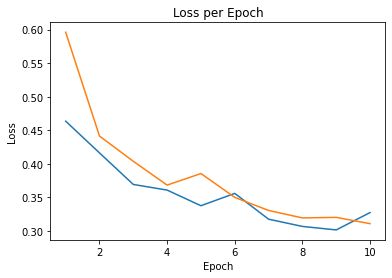

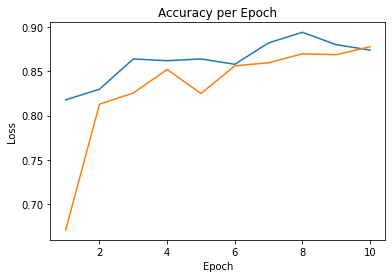

Loss of best saved model: 0.3014211763958176
Accuracy of best saved model: 0.8797595


In [121]:
# Train and Validate
model = resnet152(pretrained=True)
main_loop("./augmented_dataset", device, model, 10, "./best_model_augmented_dataset_resnet152.pth")

This is the best validation accuracy and loss yet! Let's see how it does on the test set!

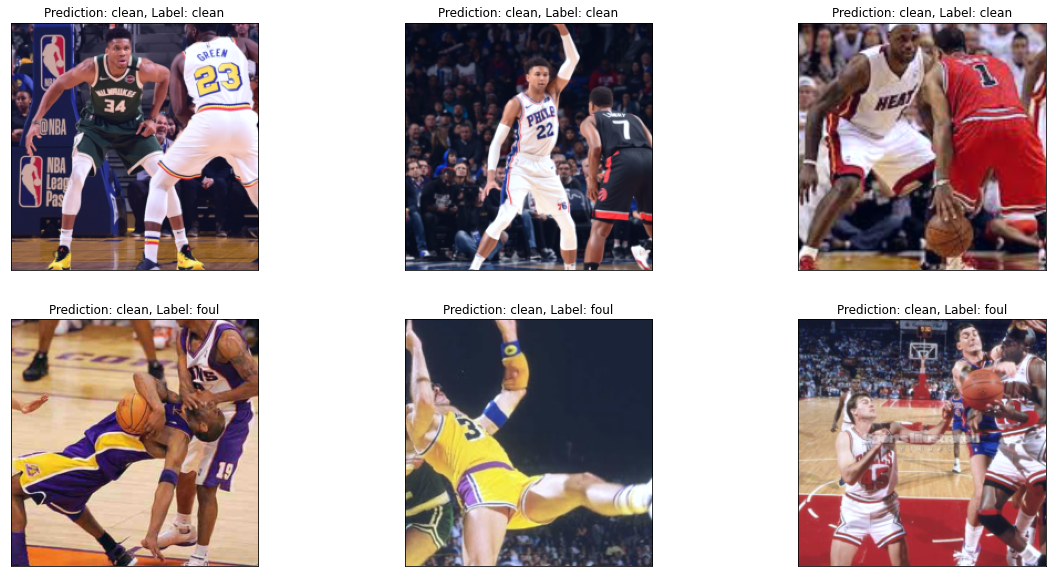


Total: 14
Correct: 11
Test Loss: 0.5594476803172646
Test Accuracy: 0.78571427


In [124]:
# Evaluate on test set
best_model = torch.load("best_model_augmented_dataset_resnet152.pth")
test_set_evaluation(best_model, criterion, test_loader, test_dataset)

Unfortunately, this validation accruacy and loss did not translate to an improvement in our test accuracy. 

### 3rd Attempted Improvement - Better Analysis: Increase Test Data Set

One thing that I realized may be skewing and hampering my analysis is the size of my test data set. It is so small that we can not get a real feel for how the model might be improving. To see if I could improve my analysis, I went back to hand collecting individual images on the Internet to get more test data images. I ended up hand collecting 60 images, about a 4x increase from before. Let's now re run the test set evaluation on all the models we have saved thus far to see how they perform on this somewhat larger dataset.

In [127]:
# Load extended hand collected test set and create data loader
test_dataset_extended = datasets.ImageFolder(root="./extended_test_dataset", transform=data_transforms)
test_loader_extended = DataLoader(test_dataset_extended, shuffle=False, batch_size=1, num_workers=1)

# Evaluate ResNet18 that was trained on initial, smaller dataset
print("\nResNet18 - Initial, Smaller Dataset", end="")
best_model = torch.load("best_model_initial_dataset.pth")
test_set_evaluation(best_model, criterion, test_loader_extended, test_dataset_extended, show_preds=False)

# Evaluate ResNet18 that was trained on augmented, larger dataset
print("\nResNet18 - Augmented, Larger Dataset", end="")
best_model = torch.load("best_model_augmented_dataset.pth")
test_set_evaluation(best_model, criterion, test_loader_extended, test_dataset_extended, show_preds=False)

# Evaluate ResNet152 that was trained on initial, smaller dataset
print("\nResNet152 - Initial, Smaller Dataset", end="")
best_model = torch.load("best_model_initial_dataset_resnet152.pth")
test_set_evaluation(best_model, criterion, test_loader_extended, test_dataset_extended, show_preds=False)

# Evaluate ResNet152 that was trained on augmented, larger dataset
print("\nResNet152 - Augmented, Larger Dataset", end="")
best_model = torch.load("best_model_augmented_dataset_resnet152.pth")
test_set_evaluation(best_model, criterion, test_loader_extended, test_dataset_extended, show_preds=False)


ResNet18 - Initial, Smaller Dataset
Total: 60
Correct: 41
Test Loss: 0.5821495352545754
Test Accuracy: 0.68333334

ResNet18 - Augmented, Larger Dataset
Total: 60
Correct: 44
Test Loss: 0.5298171529745256
Test Accuracy: 0.73333335

ResNet152 - Initial, Smaller Dataset
Total: 60
Correct: 46
Test Loss: 0.4528273519128561
Test Accuracy: 0.76666665

ResNet152 - Augmented, Larger Dataset
Total: 60
Correct: 46
Test Loss: 0.4571639505874676
Test Accuracy: 0.76666665


Just as I expected! We can see that there were actually improvements moving from the first model to the second and third. However, because my inital test data set was so small we could not "see" this earlier. When I thought there was no real improvement going from training ResNet18 on the smaller training data set to the larger augmented one, I was very surprised as I did expect a lift. And turns out there actually was a significant lift (~5%), but my data set size was limiting what I could "see." This really hits home the point of the importance of data that we have talked about so much in this class. One thing that is interesting though is that ResNet152 did not see an improved accuracy between training datasets. This makes me believe that the increased number of images for training ResNet152 is simply allowing it to fit the training data better but not generalize better.

### 4th Attempted Improvement - Fine Tuning Unfreeze

Another attempt I wanted to try was to change the way I was freezing my layers. In the previous attempts of fine tuning I froze ALL the layers except the one I added and then I trained the network this way. I did it this way because it was the way the PyTorch documentation did it and I was curious to see how it would perform. However, now I am going to try the method that we did in class which was where we trained with all the layers frozen for some number of epochs and then trained some more with all the layers unfrozen. To do this I will need to modify my main loop a bit first.

In [8]:
def main_loop_with_unfreezing(dataset_path, device, model, num_epochs, best_model_path):
    # Compose a transform to apply on input so it can be fed into Resnet
    # Found transforms expected by ResNet here: https://pytorch.org/hub/pytorch_vision_resnet/
    data_transforms = transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                   ])

    # Load the hand curated dataset
    dataset = datasets.ImageFolder(root=dataset_path, transform=data_transforms)
    print("Size of dataset: " + str(len(dataset)) + "\n")

    # Split the dataset into two sets to create a validation set.
    eighty = int(len(dataset) * 0.8)
    twenty = len(dataset) - eighty
    train_dataset, val_dataset = random_split(dataset, [eighty, twenty])

    # Create dataloaders for loaded training set and validation set of the images to feed through our network
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32, num_workers=4)
    val_loader = DataLoader(val_dataset, shuffle=True, batch_size=32, num_workers=4)     

    # Freeze the layers of the pretrained model
    for param in model.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model.fc.in_features   
    model.fc = nn.Linear(num_ftrs, 2) # we want our final fully connected layer to map to 2 outputs (i.e. our 2 classes)

    # Move the model to GPU
    model = model.to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

    # Train and validate the unfrozen layers for a number of epochs
    val_loss_log = []
    val_accuracy_log = []
    train_loss_log = []
    train_accuracy_log = []
    best_loss = None
    best_acc = None
    for epoch in range(num_epochs):
        # Train & Validate 
        train_loss, train_acc = train(model, optimizer, criterion, train_loader, device)
        val_loss, val_acc = validation(model, criterion, val_loader, device)
        
        # Store loss and accuracy of each epoch for plotting
        val_loss_log.append(val_loss)
        train_loss_log.append(train_loss)
        val_accuracy_log.append(val_acc)
        train_accuracy_log.append(train_acc)
        
        # Keep track of validation loss and monitor for saving best model
        if len(val_loss_log) == 0 or val_loss_log[-1] == min(val_loss_log):
                best_loss = val_loss
                best_acc = val_acc
                torch.save(model, best_model_path)
    
    # Unfreeze the layers of the pretrained model
    for param in model.parameters():
        param.requires_grad = True
    
    for epoch in range(num_epochs):
        # Train & Validate 
        train_loss, train_acc = train(model, optimizer, criterion, train_loader, device)
        val_loss, val_acc = validation(model, criterion, val_loader, device)
        
        # Store loss and accuracy of each epoch for plotting
        val_loss_log.append(val_loss)
        train_loss_log.append(train_loss)
        val_accuracy_log.append(val_acc)
        train_accuracy_log.append(train_acc)
        
        # Keep track of validation loss and monitor for saving best model
        if len(val_loss_log) == 0 or val_loss_log[-1] == min(val_loss_log):
                best_loss = val_loss
                best_acc = val_acc
                torch.save(model, best_model_path)
                
    # Visualize the training results
    plot_training_results(val_loss_log, val_accuracy_log, train_loss_log, train_accuracy_log, best_loss, best_acc)

Let's now train with this new fine tuning appraoch to see how our results vary. 

Size of dataset: 2491



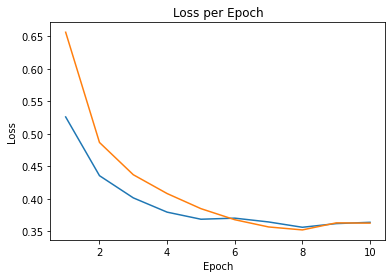

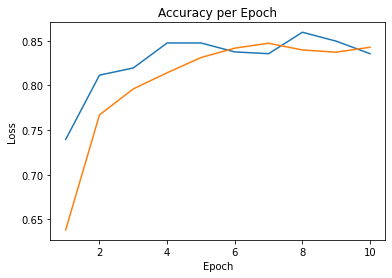

Loss of best saved model: 0.35591332551711546
Accuracy of best saved model: 0.85971946


In [131]:
# Train and Validate
model = resnet18(pretrained=True)
main_loop_with_unfreezing("./augmented_dataset", device, model, 5, "./best_model_augmented_dataset_unfreeze.pth")

These results don't differ too much from the other results we had seen earlier. But let's evalute on the test set to see as that is what is really important.

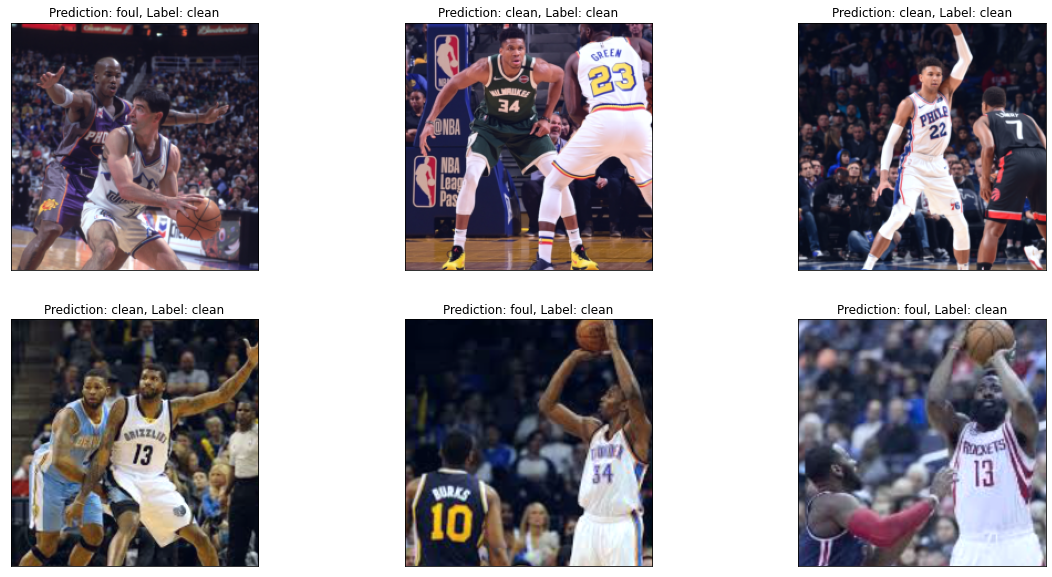


Total: 60
Correct: 42
Test Loss: 0.4935961034653398
Test Accuracy: 0.7


In [132]:
# Evaluate 
best_model = torch.load("best_model_augmented_dataset_unfreeze.pth")
test_set_evaluation(best_model, criterion, test_loader_extended, test_dataset_extended)

Interestingly, the model is actually performing worse than when we fine tuned the other way. I guess for this case the original way I performed the fine tuning was better. 

Just for completeness sake, though, let's also finetune this way with ResNet152 to see what kind of results we get.

Size of dataset: 2491



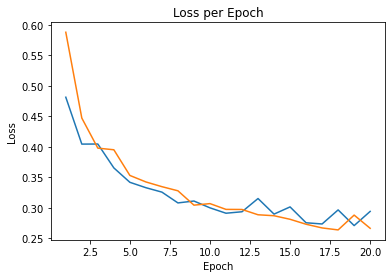

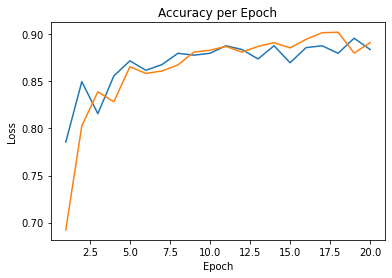

Loss of best saved model: 0.27076832756011904
Accuracy of best saved model: 0.8957915831663327


In [47]:
# Train and Validate
model = resnet152(pretrained=True)
main_loop_with_unfreezing("./augmented_dataset", device, model, 10, "./best_model_augmented_dataset_resnet152_unfreeze.pth")

That is the best validation accuracy and loss we have got yet! This might be our best model yet.

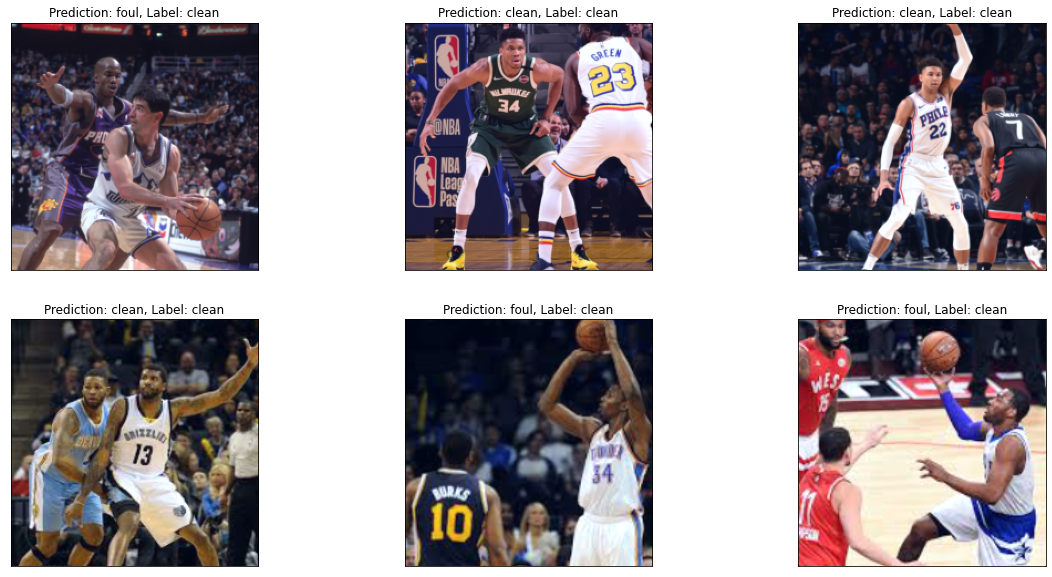


Total: 60
Correct: 42
Test Loss: 0.4789216786623001
Test Accuracy: 0.7


In [48]:
# Evaluate 
test_dataset_extended = datasets.ImageFolder(root="./extended_test_dataset", transform=data_transforms)
test_loader_extended = DataLoader(test_dataset_extended, shuffle=False, batch_size=1, num_workers=1)

best_model = torch.load("best_model_augmented_dataset_resnet152_unfreeze.pth")
test_set_evaluation(best_model, criterion, test_loader_extended, test_dataset_extended)

Unfortunately, the model did not generalize well to the test data which probably means that the extra parameters that ResNet152 provides for being a deeper network simply allowed the model to overfit the training data in this case and that is why we got such great training results but not great test results.

### 5th Attempted Improvement - Confidence Levels

Since I did not see many improvements from my last attempt another suggestion the Professor made was printing the confidence levels with the images and video data  to further my analysis to see how likely or unlikely our model feels what it is "viewing" is a foul or not. This would give us a better idea of how off the model is. Moreover, in a more real world setting, this would give the potential user of this application a notion of how likely a foul occurred or not, which would be useful. In order to do this I had to modify the following function in which I applied a Sigmoid to the output to obtain a probability / confidence level and then displayed this on my sample predictions for analysis.

In [8]:
def plot_sample_prediction(num_left_correct, num_left_wrong, image, img_array, pred, label, output, col, row, test_dataset):
    # convert from tensors to scalars
    pred = pred.cpu().numpy()[0]   
    label = label.cpu().numpy()[0] 
    
    # Apply sigmoid to prediction to map to probability / confidence level
    sigmoid = nn.Sigmoid()
    prob = sigmoid(output[0][pred].cpu()).numpy()
   
    # Check if we have already plotted 3 correct and wrong sample predictions
    if (num_left_correct == 0 and pred == label) or (num_left_wrong == 0 and pred != label):
        return row, col, num_left_correct, num_left_wrong, img_array
    
    # Un-normalize the image before displaying so that it's easier for our eyes
    unnorm_img = None
    for dim, mean, std_dev in zip(image,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)):
        unnorm_img = dim.mul_(std_dev).add_(mean)
    unnorm_img = torch.clamp(unnorm_img, min=0.0, max=1.0)  # clip image to be between +/- for matplot lib 
                
    # Create label and prediction strings
    pred_str = "Prediction: " + str(test_dataset.classes[pred])
    label_str = "Label: " + str(test_dataset.classes[label])

    # Add image with title to grid of images and remove any axis ticks
    img_array[row,col].imshow(unnorm_img.permute(1,2,0).cpu())
    img_array[row,col].set_title(pred_str + ", " + label_str, size='large')
    img_array[row,col].set_xlabel("Confidence: " + str(prob), size='large')
    img_array[row,col].get_yaxis().set_ticks([])
    img_array[row,col].get_xaxis().set_ticks([])
    
    # Decrement count for correct and wrong sample predictions available to plot on grid
    if pred == label:
        num_left_correct -= 1
    if pred != label:
         num_left_wrong -= 1 
    
    # Used to make sure row and col index correct for next sample plot
    col += 1
    if col == 3:
        row += 1
        col = 0
    if row == 2:
        row = 0
            
    return row, col, num_left_correct, num_left_wrong, img_array


I chose to evalaute using the latest saved model from the last run. Let's test this model's "confidence" now for further analysis.

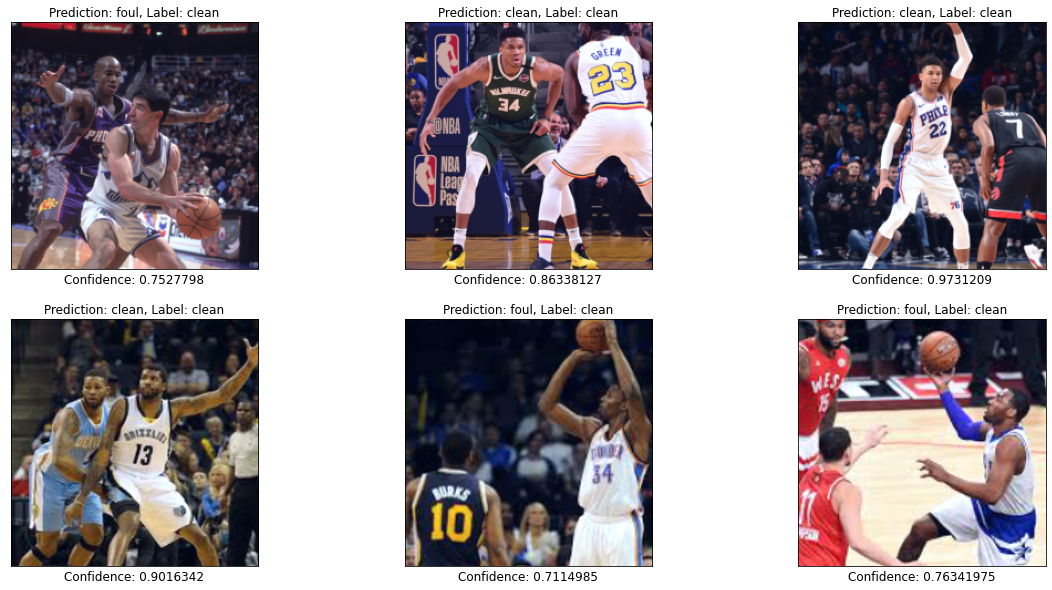


Total: 60
Correct: 42
Test Loss: 0.4789216786623001
Test Accuracy: 0.7


In [16]:
# Evaluate with confidence levels
best_model = torch.load("best_model_augmented_dataset_resnet152_unfreeze.pth")
test_set_evaluation(best_model, criterion, test_loader_extended, test_dataset_extended)

You can see above that I have now printed the confidence levels with sample predictions for analysis. From this we can see that there appears to be a certain "stance" or "pose" that the model has picked up on and is really confident in for "clean" defense. If you see the three images with the highest confidence they all have the players in similar stances compared to the other images. This is really interesting! We can see somewhat what sorts of features the model has picked up on! Also you can see for the cases that it got wrong, it was not nearly as confident compared to the predictions it got correct! This is a good sign that there is some difference in the "confidence" the model is displaying for correct and incorrect predictions. This further reassures us that the model is in fact learning.

In addition to adding the confidence level analysis to my predictions as the Professor recommended, I also added this feature to my video analysis! The source file is called 'test_video_data_conf_levels.py'. 

To run it and seem it perform run the follow the same steps outlined earlier and then run this command from the terminal: 
python3 test_video_data_conf_levels.py

## Conclusion

Overall, I had a blast with this project and am happy with my results along with the progress I made. While it was definetly a lot of work, I believe I truly understood and grasped the "ML Pipeline" by completeing this end to end project on my own. I also learned some very useful, new skills through working on the project! 

After my initial MVP version, I saw the best improvements from the data augmentation out of all my attempted improvements I believe. I did see results going from ResNet18 to ResNet152 as well but the bigger lift if you look at the accuracy results of the models on the larger test dataset came from the data augmentation. This just really hits home the point of the importance of data that this class has taught me so much through all the assignments. In fact, the biggest challenge I feel after this class in this field is data! That was definetly one of the hardest parts of this project for me.

Thank you so much to all the TAs and Professor Belhumeur for such a great term! I can not express how much I appreciate all the help you all provided. I learned an unbelievable amount and can't wait to see what lies ahead for me in this space as this course has got me extremely engaged and interested in this domain now!

## References

Thai, Sofia. “A Deep Dive Into Our DeepLens Basketball Referee.” Medium, Better Programming, 7 May 2019, medium.com/better-programming/a-deep-dive-into-our-deeplens-basketball-referee-c8ed96affd82. 

Thomas, G., Gade, R., Moeslund, T. B., Carr, P., & Hilton, A. (2017). Computer vision for sports: Current applications and research topics. Computer Vision and Image Understanding, 159, 3-18.

Suresh, Anand. “Web Scraping Images from Google.” Medium, Medium, 19 Mar. 2020, medium.com/@wwwanandsuresh/web-scraping-images-from-google-9084545808a2. 

Rath, Sovit Ranjan RathSovit Ranjan. “Action Recognition in Videos Using Deep Learning and PyTorch.” DebuggerCafe, 6 Dec. 2020, debuggercafe.com/action-recognition-in-videos-using-deep-learning-and-pytorch/. 